In [1]:
# Using pandas and numpy
import pandas as pd
import numpy as np

In [2]:
# Grabbing the data from the Pricenomics csv
df = pd.read_csv("Data+for+TreefortBnB+Puzzle.csv")

In [3]:
# Correcting and standardizing capitalization for names of cities
df.City = map(str.title, df.City)

In [4]:
# Taking a look at the data
df.head()

,Unique id,City,State,$ Price,# of Reviews
0,1,Portland,OR,75,5
1,2,San Diego,CA,95,3
2,3,New York,NY,149,37
3,4,Los Angeles,CA,199,45
4,5,Denver,CO,56,99


In [5]:
# Pivot to set row index as "City" and "State" pairs, so that cities in different states
# don't get confused for being the same thing.

# Also, aggregating price for each "City" and "State" pair by median and count (frequency of City & State pair in data)
pivotDF = pd.pivot_table(df, index=["City","State"],values=['$ Price'],aggfunc=[np.median,(lambda arr: arr.count())])

In [6]:
# Checking out the data, looks good, though column named <labmda> could be more descriptive
pivotDF.head()

,,median,<lambda>
,,$ Price,$ Price
City,State,,
Albuquerque,NM,75.0,95
Alexandria,VA,104.5,66
Anchorage,AK,123.5,50
Ann Arbor,MI,98.0,63
Arlington,VA,106.5,214


In [7]:
# Renamed '<lambdad>' as 'Listings' and median as MedianPrice
pivotDF.rename(columns={'<lambda>':'Listings', 'median': 'MedianPrice'},inplace=True)

In [8]:
# Looking at the column data to figure out how to issue commands to sort by median
pivotDF.columns

MultiIndex(levels=[[u'Listings', u'MedianPrice'], [u'$ Price']],
           labels=[[1, 0], [0, 0]])

In [9]:
# That looks like its unneccesarily two levels, lets flatten it out
pivotDF.columns =  pivotDF.columns.get_level_values(0)

In [10]:
pivotDF.head()

,,MedianPrice,Listings
City,State,,
Albuquerque,NM,75.0,95
Alexandria,VA,104.5,66
Anchorage,AK,123.5,50
Ann Arbor,MI,98.0,63
Arlington,VA,106.5,214


In [11]:
# Sorting by median, and then sorting within that sort by frequency of the city state pair in the data set
pivotDF.sort_values(["MedianPrice", "Listings"],ascending=False, inplace=True)

In [12]:
# Taking a look at the results
print(pivotDF.head(100).to_string())

                         MedianPrice  Listings
City              State                       
Indianapolis      IN           650.0       251
Madison           CT           450.0         1
Paris             TX           439.0         1
Carmel            CA           350.0        31
Malibu            CA           304.0        92
Park City         UT           299.0       229
Truckee           NV           275.0        67
Healdsburg        CA           275.0        49
Laguna Beach      CA           268.5        68
Incline Village   NV           259.0       118
Brookline         NH           250.0         2
Manhattan Beach   CA           209.0        55
Hollywood         CA           205.0         8
Charlotte         NC           200.0       225
Sonoma            CA           200.0       115
Napa              CA           200.0        68
Long Beach        NY           200.0         3
Austin            TX           199.0      2836
La Jolla          CA           195.0        53
Sausalito    

In [13]:
# Prompt wants just the top 100 highest median priced Trees - taking that slice of data and saving it as a DataFrame
top100df = pivotDF[0:100]

In [14]:
# Writing this dataframe to a file for distribution.
top100df.to_csv("TreeNB.csv")

In [15]:
# Looks good, but is a little boring, since this is just reflecting the owners choice of price.
# Lets use '# of reviews' multiplied by "median price" as a proxy for best markets to actually rent a treefort?
reviewsDF = pd.pivot_table(df, index=["City","State"],values=['# of Reviews'],aggfunc=sum)

In [16]:
# For convenience, lets make a list of the data tables we are working with
frames = [pivotDF, reviewsDF]

In [17]:
# Now lets join the tables together
finalDF = pd.concat(frames, axis=1)

In [18]:
# And lets also create that proxy by multiplying "# of reviews" by "MedianPrice"
finalDF["MinRevenue"] = finalDF['MedianPrice'] * finalDF['# of Reviews']

In [19]:
# Now lets sort by revenue, and then sorting within that sort by median
finalDF.sort_values(["MinRevenue","MedianPrice"],ascending=False, inplace=True)

In [20]:
# I am also kind of curious about the average number of reviews per listing.
# Should give us a sense of the amount of occupancy / turnover of units per geography.
finalDF["ReviewsPerListing"] = finalDF['# of Reviews'] / finalDF['Listings']

In [21]:
print(finalDF.head(100).to_string())

                         MedianPrice  Listings  # of Reviews  MinRevenue  ReviewsPerListing
City              State                                                                    
New York          NY           170.0      8044         64177  10910090.0           7.978245
San Francisco     CA           150.0      3622         30842   4626300.0           8.515185
Brooklyn          NY           110.0      4368         33154   3646940.0           7.590201
Los Angeles       CA           110.0      3236         21723   2389530.0           6.712917
Austin            TX           199.0      2836         10575   2104425.0           3.728843
Washington        DC           129.0      1402          9163   1182027.0           6.535663
Chicago           IL           100.0      1255         11248   1124800.0           8.962550
Miami Beach       FL           150.0      1345          7126   1068900.0           5.298141
Seattle           WA           100.0       824          9772    977200.0        

In [22]:
# Interesting stuff. A few outliers, like Indianapolis with $650 median now seem to have a tradeoff with turnover.
# Is there any geographic clustering here? Lets see with a visualization.
# First, lets get the lat and long coordinates of these cities.
# We'll use the geocoder module to pull latitude and longitude for each of the cities to then plot.
import geocoder

In [23]:
# Grabs the list of city and state pairs in our finalDF
LocationList = list(finalDF.index.values)

In [24]:
# Lets write a function to loop through each city state pair and get its latitude and longitude
latlngList = []

def locExtractor(array):
    for i in array:
        g = geocoder.google(i)
        latlngList.append(g.latlng)

In [25]:
# Lets get those coordinates
locExtractor(LocationList)

In [26]:
latlngList

[[40.7127837, -74.0059413],
 [37.7749295, -122.4194155],
 [40.6781784, -73.9441579],
 [34.0522342, -118.2436849],
 [30.267153, -97.7430608],
 [47.7510741, -120.7401386],
 [41.8781136, -87.6297982],
 [25.790654, -80.1300455],
 [47.6062095, -122.3320708],
 [29.95106579999999, -90.0715323],
 [42.3600825, -71.0588801],
 [45.5230622, -122.6764816],
 [32.715738, -117.1610838],
 [39.9525839, -75.1652215],
 [25.7616798, -80.1917902],
 [34.0194543, -118.4911912],
 [40.7282239, -73.7948516],
 [52.205337, 0.121817],
 [39.768403, -86.158068],
 [21.3069444, -157.8583333],
 [37.8043637, -122.2711137],
 [39.7392358, -104.990251],
 [45.4408474, 12.3155151],
 [38.291859, -122.4580356],
 [37.8718992, -122.2585399],
 [36.1626638, -86.7816016],
 [36.1699412, -115.1398296],
 [36.9741171, -122.0307963],
 [33.7489954, -84.3879824],
 [34.0900091, -118.3617443],
 [32.0835407, -81.09983419999999],
 [40.0149856, -105.2705456],
 [42.3875968, -71.0994968],
 [40.6460622, -111.4979729],
 [35.2270869, -80.8431267],
 

In [27]:
# The plotting function we work with requires the coordinates seperated into longitude and latitude, so lets write
# a loop to seperate them into their own lists
latList = []
lngList = []

try:
    for lat, lng in latlngList:
        latList.append(lat)
        lngList.append(lng)
except:
    pass

In [28]:
# lets add the coordinates to the dataframe, so that they are matched up with their city & state pairs, even if data
# gets sorted or jumbled (or in this example, eventually turned into a dictionary, where row order gets tossed around)
finalDF['Latitude'] = pd.Series(latList, index=finalDF.index.values)

In [29]:
finalDF['Longitude'] = pd.Series(lngList, index=finalDF.index.values)

In [30]:
# Lets take a look
finalDF.head()

,,MedianPrice,Listings,# of Reviews,MinRevenue,ReviewsPerListing,Latitude,Longitude
City,State,,,,,,,
New York,NY,170.0,8044,64177,10910090.0,7.978245,40.712784,-74.005941
San Francisco,CA,150.0,3622,30842,4626300.0,8.515185,37.774929,-122.419415
Brooklyn,NY,110.0,4368,33154,3646940.0,7.590201,40.678178,-73.944158
Los Angeles,CA,110.0,3236,21723,2389530.0,6.712917,34.052234,-118.243685
Austin,TX,199.0,2836,10575,2104425.0,3.728843,30.267153,-97.743061


In [31]:
# now lets transform the dataframe into dictionaries to create index and column value pairs
dicts = finalDF.to_dict()

In [32]:
# saving the index and "MinRevenue" matching pairs
rev = dicts['MinRevenue']

In [33]:
# saving the index and "MedianPrice" matching pairs
median = dicts['MedianPrice']

In [34]:
# saving the index and "Latitude" matching pairs
lat = dicts['Latitude']

In [35]:
# saving the index and "Longitude" matching pairs
lon = dicts['Longitude']

In [36]:
# Lets get the modules to start plotting
import pylab as plt
from mpl_toolkits.basemap import Basemap
plt.close('all')

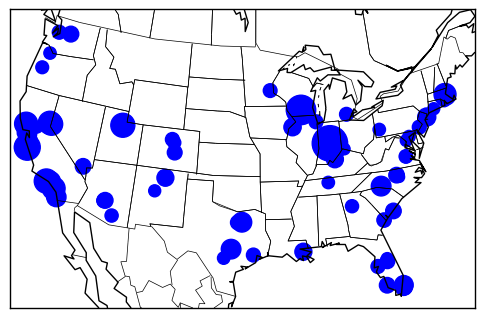

In [37]:
# Lets draw the map of the United States, and translate those latitude and longitude values to x,y coordinates.

m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
projection='lcc',lat_1=33,lat_2=45,lon_0=-95,resolution='c')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
longs = lon.values()
lats = lat.values()
x, y = m(longs, lats)

# Lets represent the size of the dots on this map as the median price.

z = median.values()
m.scatter(x=x, y=y, s=z, marker='o',color='b')
plt.show()

In [38]:
# First, lets scale the Revenue values to be in roughly the same significant figures as median values.
z2 = rev.values()
z2scaled = map(lambda x: x / 10000,z2)

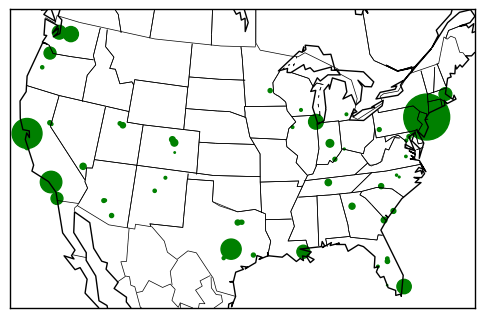

In [39]:
#  Now lets plot the minimum revenue per city from Treeforts.

m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
projection='lcc',lat_1=33,lat_2=45,lon_0=-95,resolution='c')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
longs = lon.values()
lats = lat.values()
x, y = m(longs, lats)

# This time the size of the dots (s) will be z2scaled instead - the Minimum Revenue for each city.

m.scatter(x=x, y=y, s=z2scaled, marker='o',color='g')
plt.show()

In [40]:
# Interesting. The blue dots represent median, the green represent minimum revenue.
# There is a huge difference between the two. Owners are setting all sorts of prices all over the United States...
# But the cities with the highest revenue don't seem to have the highest median price.

# I wonder if this represents a key difference in the forts. Perhaps outside of major dense cities, like SF and NY, 
# Treeforts on TreeFort BNB are so large that they can't be reasonably rented below a certain price.

# Would be interesting to see if we could have an "Average Square Foot" column to also help us study correlations here.